In [ ]:

import os
import cooler
import cooltools
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import bioframe
import numpy as np
from functools import partial
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 70
mpl.rcParams['font.size'] = 15
import logging
logging.getLogger('fontTools.subset').setLevel(logging.WARNING)
from concurrent import futures
import warnings
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.WARNING)
import seaborn as sns
resolution = 1_000_000 #1_000_000 10_000 100_000
norm_fun='norm_range' #norm_range,smallest,multiplicative
genome_fa='/home/goubo/reference/index/bowtie2/mm10/raw/mm10.fa'
# main_samples=['E11.5L2','E12.5L6','E13.5C1','E14.5F6']
# kept_samples= ['E11.5L1', 'E11.5L2', 'E12.5L5', 'E12.5L6', 'E13.5C1', 
#                 'E13.5C4', 'E13.5C6', 'E14.5F5', 'E14.5F6']

proj_dir='/home/goubo/CRICK/CRICK/spaceA'
work_dir=os.path.join(proj_dir,'higashi_v2/higashi')
out_dir=os.path.join(work_dir,'hic')
os.makedirs(out_dir,exist_ok=True)
os.chdir(out_dir)

In [2]:
################# bulk_hic
bulk_hic_dir=os.path.join(proj_dir,'bulkhicData')
bulk_hic_samples=['E13.5body','E13.5brain','E13.5liver']
bulk_hic_samples_labels=['Bulk Hi-C E13.5 Body','Bulk Hi-C E13.5 Brain','Bulk Hi-C E13.5 Liver']
bulk_hic_cool_files_path=[os.path.join(bulk_hic_dir,x+'.allValidPairs_0.mcool'+ "::/resolutions/"+ str(resolution)) for x in bulk_hic_samples]
bulk_hic_colors=['#3182BD','#6BAED6','#9ECAE1']
# https://matplotlib.org/stable/users/explain/colors/colormaps.html

################# GSE_hic
GSE_hic_samples=['cardic_hic','PL_hic','DL_hic']
GSE_hic_samples_labels=['Bulk Hi-C GSE195905 \nE12.5 cardiomyocytes', 'Bulk Hi-C GSE101715 \nE12.5 proximal limbs' ,'Bulk Hi-C GSE101715 \nE12.5 distal limbs']

GSE_hic_cool_files_path=["/home/goubo/CRICK/Hi-C/mouse_E12toP42_cardiomyocytes_hic_hichip_RNA_p300_developmentcell_2023/file_convert/SRR17681562/SRR17681562.allValidPairs_0.mcool"+ "::/resolutions/" + str(resolution), 
    "/home/goubo/CRICK/Hi-C/mouse_E12_limb_hic_BMCBiology/file_convert/PL/PL.allValidPairs_0.mcool"+ "::/resolutions/"+ str(resolution), 
    "/home/goubo/CRICK/Hi-C/mouse_E12_limb_hic_BMCBiology/file_convert/DL/DL.allValidPairs_0.mcool"+ "::/resolutions/"+ str(resolution),]
GSE_hic_colors=["#756BB1","#9E9AC8","#DADAEB"]

################# spaceA
spaceA_samples=['E11.5L1', 'E11.5L2', 'E12.5L5', 'E12.5L6', 'E13.5C1', 
                'E13.5C4', 'E13.5C6', 'E14.5F5', 'E14.5F6']

spaceA_samples_labels=['SpaceA combined '+x for x in spaceA_samples]
spaceA_cool_dir=os.path.join(proj_dir,'data_convert_fs/higashi_v2/fh_leiden_anno_man')
spaceA_cool_files_path=[os.path.join(spaceA_cool_dir,x+'_combined_0.mcool'+ "::/resolutions/"+ str(resolution)) for x in spaceA_samples]
spaceA_colors=sns.color_palette("YlOrRd_r", len(spaceA_samples)) #CMRmap YlOrRd_r

################ bulk SPRITE
bulk_SPRITE_dir=os.path.join(proj_dir,'bulkSpriteData')
bulk_SPRITE_samples=['E13.5face','E13.5brain','E13.5liver']
bulk_SPRITE_samples_labels=['Bulk SPRITE E13.5 Face','Bulk SPRITE E13.5 Brain','Bulk SPRITE E13.5 Liver']
bulk_SPRITE_cool_files_path=[os.path.join(bulk_SPRITE_dir,'bulk_sprite_'+x+'_0.mcool'+ "::/resolutions/"+ str(resolution)) for x in bulk_SPRITE_samples]
bulk_SPRITE_colors=['#31A354','#74C476','#A1D99B']


In [4]:
all_samples=spaceA_samples+bulk_hic_samples+GSE_hic_samples
all_samples_labels =spaceA_samples_labels+bulk_hic_samples_labels+GSE_hic_samples_labels
all_cool_files_path=spaceA_cool_files_path+bulk_hic_cool_files_path+GSE_hic_cool_files_path
all_sample_colors=spaceA_colors+bulk_hic_colors+GSE_hic_colors


In [5]:
# mcool_to_cool_and_hicNormalize
hicNormalize='/home/goubo/miniconda3/envs/hicexplorer/bin/hicNormalize'

all_norm_cool_files_path=[x.replace('0.mcool::/resolutions/'+str(resolution),
                                    str(resolution)+ f'.{norm_fun}.cool') for x in all_cool_files_path]

if not all([os.path.exists(x) for x in all_norm_cool_files_path]):
    subprocess.run(f'{hicNormalize} --matrices {" ".join(all_cool_files_path)} --normalize {norm_fun} \
                --outFileName {" ".join(all_norm_cool_files_path)}',shell=True)


#### 3. 计算Smoothing & aggregating P(s) curves

In [6]:
subprocess.run(f'if [ ! -f gap.txt.gz ]; then wget https://hgdownload.soe.ucsc.edu/goldenPath/mm10/database/gap.txt.gz --quiet;fi', shell=True)
mm10_gap=pd.read_table('gap.txt.gz',names=['bin','chrom','start','end','ix','n','size','type','bridge']) 

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
exclude_chroms=['chrX','chrY','chrM']
mm10_chromsizes=mm10_chromsizes.drop(exclude_chroms)
mm10_chromsizes = (pd.DataFrame(mm10_chromsizes).reset_index().rename(columns={"name": 'chrom'}))
mm10_cens=mm10_gap[mm10_gap['type']=='centromere'][['chrom','start','end']]
mm10_cens['mid']=mm10_cens.apply(lambda x: (int(x['start'])+int(x['end']))//2,axis='columns')
mm10_cens=mm10_cens.query("chrom not in @exclude_chroms")
# create a view with chromosome arms using chromosome sizes and definition of centromeres
mm10_arms = bioframe.make_chromarms(mm10_chromsizes,mm10_cens)
# select only those chromosomes available in cooler
mm10_arms = mm10_arms.query("chrom not in @exclude_chroms").reset_index(drop=True)
# mm10_arms.head()

In [7]:
def _cal_cvd_merged_of_cool(coolfile:str,resolution:int,cpus:int,view_df:pd.DataFrame) -> pd.DataFrame:
    subprocess.run(f'cooler balance {coolfile} --nproc {cpus}', shell=True)
    clr = cooler.Cooler(coolfile)
    cvd_smooth_agg = cooltools.expected_cis(clr=clr,view_df=view_df,smooth=True,intra_only=True,
                                            aggregate_smoothed=True,nproc=cpus)
    cvd_smooth_agg['s_bp'] = cvd_smooth_agg['dist']* resolution
    cvd_smooth_agg['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg['dist'] < 2] = np.nan
    # Just take a single value for each genomic separation
    cvd_merged = cvd_smooth_agg.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    return cvd_merged

In [8]:
cpus=20
with futures.ProcessPoolExecutor(max_workers=cpus) as pool:
    cvd_merged_res= list(pool.map(partial(_cal_cvd_merged_of_cool,resolution=resolution,
                                          cpus=60,view_df=mm10_arms),all_norm_cool_files_path))


INFO:root:creating a Pool of 60 workers
INFO:root:creating a Pool of 60 workers
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
INFO:root:creating a Pool of 60 workers
INFO:root:creating a Pool of 60 workers
INFO:root:creating a Pool of 60 workers
INFO:root:creating a

#### 4. 绘制Contact vs Distance图

In [9]:
import matplotlib.ticker as ticker

def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

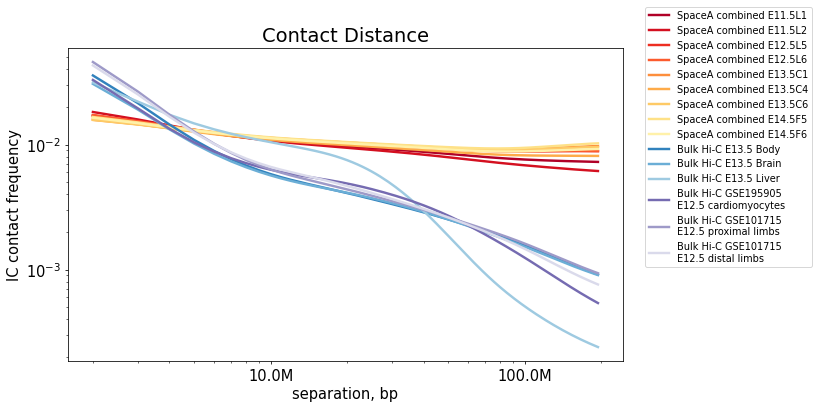

In [10]:
f, ax = plt.subplots(1,1,figsize=(12,6))
for i,(sample,label,cool_f,color) in enumerate(zip(all_samples,all_samples_labels,all_cool_files_path,all_sample_colors)):
    ax.loglog(cvd_merged_res[i]['s_bp'],cvd_merged_res[i]['balanced.avg.smoothed.agg'],
                '-',markersize=5,label=label,color=color, lw=2.5)

ax.set(xlabel='separation, bp',  ylabel='IC contact frequency')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
ax.set_xlabel('separation, bp', fontsize=15)
ax.set_ylabel('IC contact frequency', fontsize=15)
ax.set_title('Contact Distance',fontsize=20);
ax.legend(loc=(1.04, 0.3), fontsize=10)
f.tight_layout()
f.show()
f.savefig(f'Lineplot_ContactDistance.pdf')
f.savefig(f'Lineplot_ContactDistance.png')


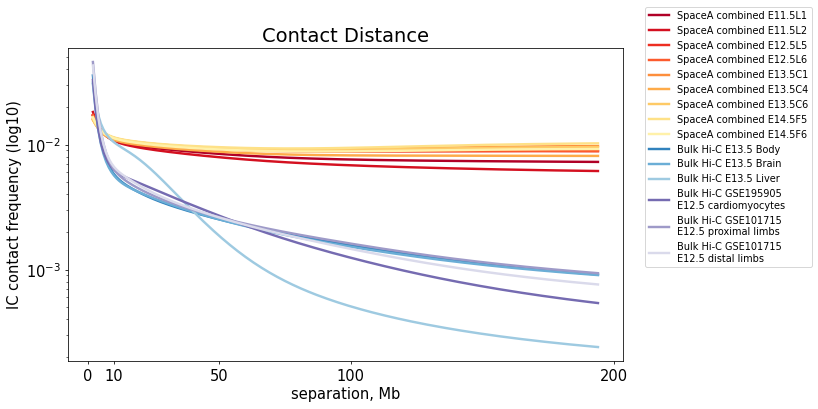

In [11]:
f1, ax1 = plt.subplots(1,1,figsize=(12,6))

for i,(sample,label,cool_f,color) in enumerate(zip(all_samples,all_samples_labels,all_cool_files_path,all_sample_colors)):
        ax1.plot(cvd_merged_res[i]['s_bp'], cvd_merged_res[i]['balanced.avg.smoothed.agg'],
                '-',markersize=5,label=label,color=color, lw=2.5)

ax1.set(xlabel='separation, bp',  ylabel='IC contact frequency')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
ax1.set_xlabel('separation, Mb', fontsize=15)
ax1.set_ylabel('IC contact frequency (log10)', fontsize=15)
ax1.set_title('Contact Distance',fontsize=20);
ax1.set_yscale("log", base=10);
ax1.set_xticks([0,10e6,50e6,100e6,200e6], labels=[0,10,50,100,200])
ax1.legend(loc=(1.04, 0.3), fontsize=10)
f1.tight_layout()
f1.show()
f1.savefig(f'Lineplot_ContactDistance_new.pdf')
f1.savefig(f'Lineplot_ContactDistance_new.png')
